<font face = "Verdana" size ="5">This notebook tracks the spread of the novel coronavirus, also known as SARS-CoV-2. It is a contagious respiratory virus that first started in Wuhan in December 2019. On 2/11/2020, the disease is officially named COVID-19 by the World Health Organization. 
    <br><br>Data: <a href='https://github.com/CSSEGISandData/COVID-19'>https://github.com/CSSEGISandData/COVID-19</a>
    <br>Learn more from the <a href='https://www.who.int/emergencies/diseases/novel-coronavirus-2019'>WHO</a>
    <br>Learn more from the <a href='https://www.cdc.gov/coronavirus/2019-ncov'>CDC</a>
    <br>Map Visualizations from  <a href='https://gisanddata.maps.arcgis.com/apps/opsdashboard/index.html#/bda7594740fd40299423467b48e9ecf6'>Johns Hopkins</a>
    <br>Source code is on <a href='https://github.com/therealcyberlord'>my Github</a>
   </font>
   <br>
   <font face = "Verdana" size ="4">
   <br>Feel free to provide me with feedbacks. 
    <br> Last update: 3/28/2020 9:56 PM
    <br> Make sure you run the notebook to see the graphs better. Some diagrams are hard to see in the default view. 
 </font>
 <font face = "Verdana" size ="1">
<center><img src='https://newsfortomorrow.com/wp-content/uploads/2020/01/1578562454_Wuhan-pneumonia-New-coronavirus-related-to-SARS-idenitified.jpg'>
 Source: https://newsfortomorrow.com/wp-content/uploads/2020/01/1578562454_Wuhan-pneumonia-New-coronavirus-related-to-SARS-idenitified.jpg </center> 
    
 <font face = "Verdana" size ="4"> Keep strong, world! Stay safe. </font>







In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
import matplotlib.colors as mcolors
import pandas as pd 
import random
import math
import time
from sklearn.linear_model import LinearRegression, BayesianRidge
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error
import datetime
import operator 
plt.style.use('fivethirtyeight')
%matplotlib inline 

Import the data (make sure you update this on a daily basis)

In [2]:
confirmed_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')
deaths_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv')
recoveries_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv')

In [3]:
confirmed_df.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,3/19/20,3/20/20,3/21/20,3/22/20,3/23/20,3/24/20,3/25/20,3/26/20,3/27/20,3/28/20
0,NaN,Afghanistan,33.0000,65.0000,0,0,0,0,0,0,...,22,24,24,40,40,74,84,94,110,110
1,NaN,Albania,41.1533,20.1683,0,0,0,0,0,0,...,64,70,76,89,104,123,146,174,186,197
2,NaN,Algeria,28.0339,1.6596,0,0,0,0,0,0,...,87,90,139,201,230,264,302,367,409,454
3,NaN,Andorra,42.5063,1.5218,0,0,0,0,0,0,...,53,75,88,113,133,164,188,224,267,308
4,NaN,Angola,-11.2027,17.8739,0,0,0,0,0,0,...,0,1,2,2,3,3,3,4,4,5


In [4]:
cols = confirmed_df.keys()

Get all the dates for the outbreak

In [5]:
confirmed = confirmed_df.loc[:, cols[4]:cols[-1]]
deaths = deaths_df.loc[:, cols[4]:cols[-1]]
recoveries = recoveries_df.loc[:, cols[4]:cols[-1]]

In [6]:
dates = confirmed.keys()
world_cases = []
total_deaths = [] 
mortality_rate = []
recovery_rate = [] 
total_recovered = [] 
total_active = [] 
china_cases = [] 
italy_cases = []
us_cases = [] 
spain_cases = [] 

for i in dates:
    confirmed_sum = confirmed[i].sum()
    death_sum = deaths[i].sum()
    recovered_sum = recoveries[i].sum()
    
    # confirmed, deaths, recovered, and active
    world_cases.append(confirmed_sum)
    total_deaths.append(death_sum)
    total_recovered.append(recovered_sum)
    total_active.append(confirmed_sum-death_sum-recovered_sum)
    
    # calculate rates
    mortality_rate.append(death_sum/confirmed_sum)
    recovery_rate.append(recovered_sum/confirmed_sum)

    # case studies 
    china_cases.append(confirmed_df[confirmed_df['Country/Region']=='China'][i].sum())
    italy_cases.append(confirmed_df[confirmed_df['Country/Region']=='Italy'][i].sum())
    us_cases.append(confirmed_df[confirmed_df['Country/Region']=='US'][i].sum())
    spain_cases.append(confirmed_df[confirmed_df['Country/Region']=='Spain'][i].sum())

Getting daily increases

In [7]:
def daily_increase(data):
    d = [] 
    for i in range(len(data)):
        if i == 0:
            d.append(data[0])
        else:
            d.append(data[i]-data[i-1])
    return d 

world_daily_increase = daily_increase(world_cases)
china_daily_increase = daily_increase(china_cases)
italy_daily_increase = daily_increase(italy_cases)
us_daily_increase = daily_increase(us_cases)
spain_daily_increase = daily_increase(spain_cases)

In [8]:
days_since_1_22 = np.array([i for i in range(len(dates))]).reshape(-1, 1)
world_cases = np.array(world_cases).reshape(-1, 1)
total_deaths = np.array(total_deaths).reshape(-1, 1)
total_recovered = np.array(total_recovered).reshape(-1, 1)

Future forcasting

In [9]:
days_in_future = 10
future_forcast = np.array([i for i in range(len(dates)+days_in_future)]).reshape(-1, 1)
adjusted_dates = future_forcast[:-10]

Convert integer into datetime for better visualization

In [10]:
start = '1/22/2020'
start_date = datetime.datetime.strptime(start, '%m/%d/%Y')
future_forcast_dates = []
for i in range(len(future_forcast)):
    future_forcast_dates.append((start_date + datetime.timedelta(days=i)).strftime('%m/%d/%Y'))

In [11]:
X_train_confirmed, X_test_confirmed, y_train_confirmed, y_test_confirmed = train_test_split(days_since_1_22, world_cases, test_size=0.05, shuffle=False) 

Model for predicting # of confirmed cases. I am using support vector machine, bayesian ridge , and linear regression in this example. 

In [12]:
# use this to find the optimal parameters for SVR
# c = [0.01, 0.1, 1]
# gamma = [0.01, 0.1, 1]
# epsilon = [0.01, 0.1, 1]
# shrinking = [True, False]
# degree = [3, 4, 5, 6, 7]

# svm_grid = {'C': c, 'gamma' : gamma, 'epsilon': epsilon, 'shrinking' : shrinking, 'degree': degree}

# svm = SVR(kernel='poly')
# svm_search = RandomizedSearchCV(svm, svm_grid, scoring='neg_mean_squared_error', cv=3, return_train_score=True, n_jobs=-1, n_iter=30, verbose=1)
# svm_search.fit(X_train_confirmed, y_train_confirmed)

In [13]:
# svm_search.best_params_

In [14]:
# svm_confirmed = svm_search.best_estimator_
svm_confirmed = SVR(shrinking=True, kernel='poly',gamma=0.01, epsilon=1,degree=8, C=0.1)
svm_confirmed.fit(X_train_confirmed, y_train_confirmed)
svm_pred = svm_confirmed.predict(future_forcast)

/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MAE: 25758.647810962982
MSE: 669252013.1201617


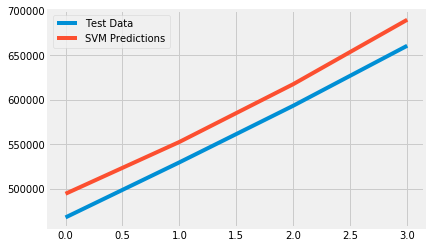

In [15]:
# check against testing data
svm_test_pred = svm_confirmed.predict(X_test_confirmed)
plt.plot(y_test_confirmed)
plt.plot(svm_test_pred)
plt.legend(['Test Data', 'SVM Predictions'])
print('MAE:', mean_absolute_error(svm_test_pred, y_test_confirmed))
print('MSE:',mean_squared_error(svm_test_pred, y_test_confirmed))

In [16]:
# transform our data for polynomial regression
poly = PolynomialFeatures(degree=6)
poly_X_train_confirmed = poly.fit_transform(X_train_confirmed)
poly_X_test_confirmed = poly.fit_transform(X_test_confirmed)
poly_future_forcast = poly.fit_transform(future_forcast)

In [17]:
# polynomial regression
linear_model = LinearRegression(normalize=True, fit_intercept=False)
linear_model.fit(poly_X_train_confirmed, y_train_confirmed)
test_linear_pred = linear_model.predict(poly_X_test_confirmed)
linear_pred = linear_model.predict(poly_future_forcast)
print('MAE:', mean_absolute_error(test_linear_pred, y_test_confirmed))
print('MSE:',mean_squared_error(test_linear_pred, y_test_confirmed))

MAE: 6285.400955549849
MSE: 51026251.30693969


In [18]:
print(linear_model.coef_)

[[ 2.67941050e+03 -1.97257923e+03  4.31334359e+02 -1.45311899e+01
   2.47223153e-01 -3.61392920e-03  3.52434863e-05]]


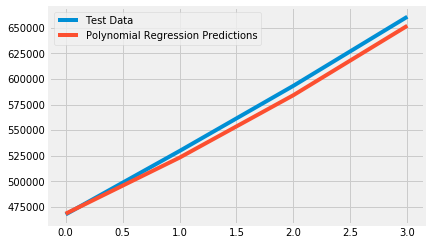

In [19]:
plt.plot(y_test_confirmed)
plt.plot(test_linear_pred)
plt.legend(['Test Data', 'Polynomial Regression Predictions'])

In [20]:
# bayesian ridge polynomial regression
tol = [1e-4, 1e-3, 1e-2]
alpha_1 = [1e-7, 1e-6, 1e-5, 1e-4]
alpha_2 = [1e-7, 1e-6, 1e-5, 1e-4]
lambda_1 = [1e-7, 1e-6, 1e-5, 1e-4]
lambda_2 = [1e-7, 1e-6, 1e-5, 1e-4]

bayesian_grid = {'tol': tol, 'alpha_1': alpha_1, 'alpha_2' : alpha_2, 'lambda_1': lambda_1, 'lambda_2' : lambda_2}

bayesian = BayesianRidge(fit_intercept=False, normalize=True)
bayesian_search = RandomizedSearchCV(bayesian, bayesian_grid, scoring='neg_mean_squared_error', cv=3, return_train_score=True, n_jobs=-1, n_iter=40, verbose=1)
bayesian_search.fit(poly_X_train_confirmed, y_train_confirmed)

Fitting 3 folds for each of 40 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    2.4s finished
/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
                   estimator=BayesianRidge(alpha_1=1e-06, alpha_2=1e-06,
                                           compute_score=False, copy_X=True,
                                           fit_intercept=False, lambda_1=1e-06,
                                           lambda_2=1e-06, n_iter=300,
                                           normalize=True, tol=0.001,
                                           verbose=False),
                   iid='warn', n_iter=40, n_jobs=-1,
                   param_distributions={'alpha_1': [1e-07, 1e-06, 1e-05,
                                                    0.0001],
                                        'alpha_2': [1e-07, 1e-06, 1e-05,
                                                    0.0001],
                                        'lambda_1': [1e-07, 1e-06, 1e-05,
                                                     0.0001],
                                        'lambda_2': [1e

In [21]:
bayesian_search.best_params_

{'tol': 0.001,
 'lambda_2': 0.0001,
 'lambda_1': 1e-06,
 'alpha_2': 1e-05,
 'alpha_1': 0.0001}

In [22]:
bayesian_confirmed = bayesian_search.best_estimator_
test_bayesian_pred = bayesian_confirmed.predict(poly_X_test_confirmed)
bayesian_pred = bayesian_confirmed.predict(poly_future_forcast)
print('MAE:', mean_absolute_error(test_bayesian_pred, y_test_confirmed))
print('MSE:',mean_squared_error(test_bayesian_pred, y_test_confirmed))

MAE: 68933.34022650296
MSE: 5436842797.98537


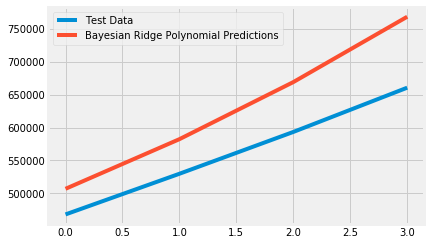

In [23]:
plt.plot(y_test_confirmed)
plt.plot(test_bayesian_pred)
plt.legend(['Test Data', 'Bayesian Ridge Polynomial Predictions'])

 Graphing the number of confirmed cases, active cases, deaths, recoveries, mortality rate, and recovery rate

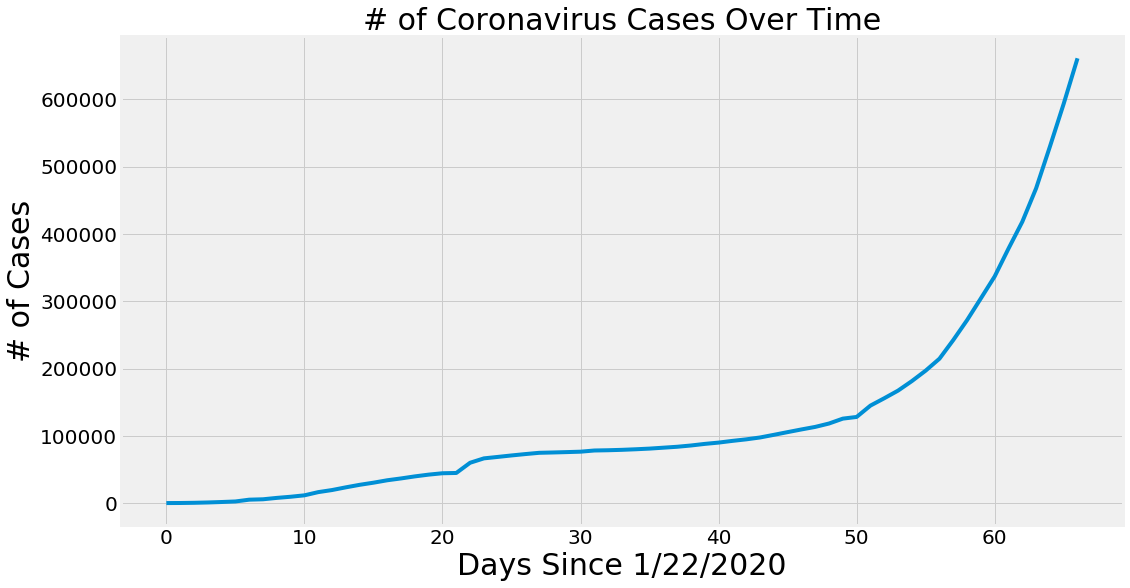

In [24]:
adjusted_dates = adjusted_dates.reshape(1, -1)[0]
plt.figure(figsize=(16, 9))
plt.plot(adjusted_dates, world_cases)
plt.title('# of Coronavirus Cases Over Time', size=30)
plt.xlabel('Days Since 1/22/2020', size=30)
plt.ylabel('# of Cases', size=30)
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

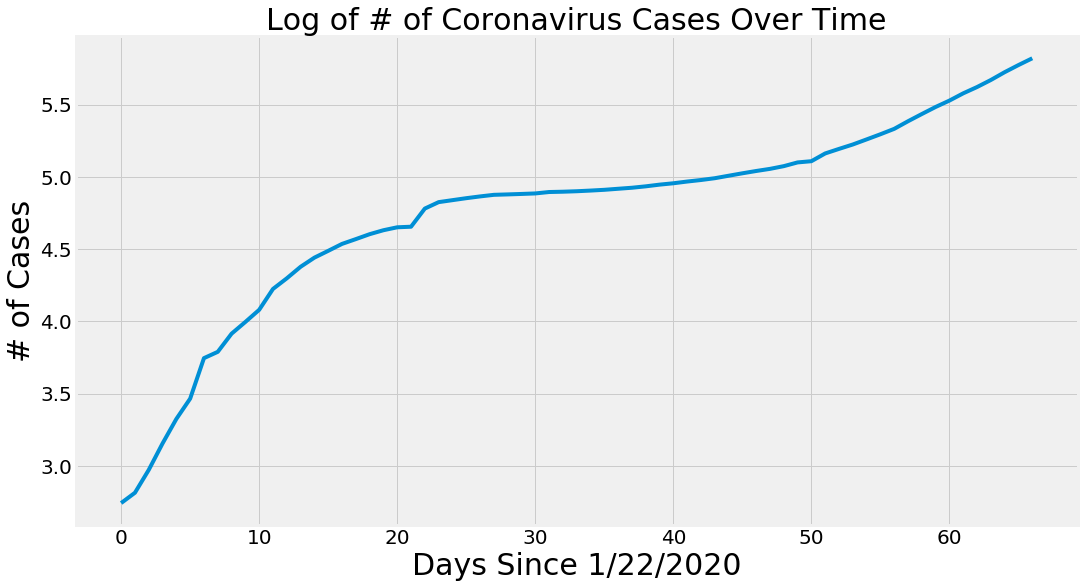

In [25]:
plt.figure(figsize=(16, 9))
plt.plot(adjusted_dates, np.log10(world_cases))
plt.title('Log of # of Coronavirus Cases Over Time', size=30)
plt.xlabel('Days Since 1/22/2020', size=30)
plt.ylabel('# of Cases', size=30)
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

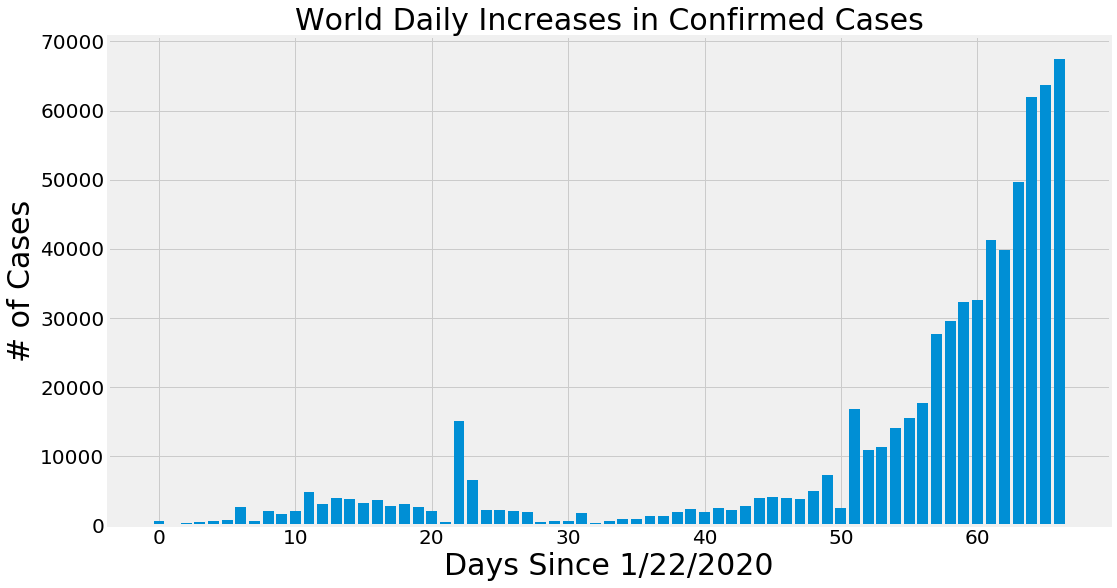

In [26]:
plt.figure(figsize=(16, 9))
plt.bar(adjusted_dates, world_daily_increase)
plt.title('World Daily Increases in Confirmed Cases', size=30)
plt.xlabel('Days Since 1/22/2020', size=30)
plt.ylabel('# of Cases', size=30)
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

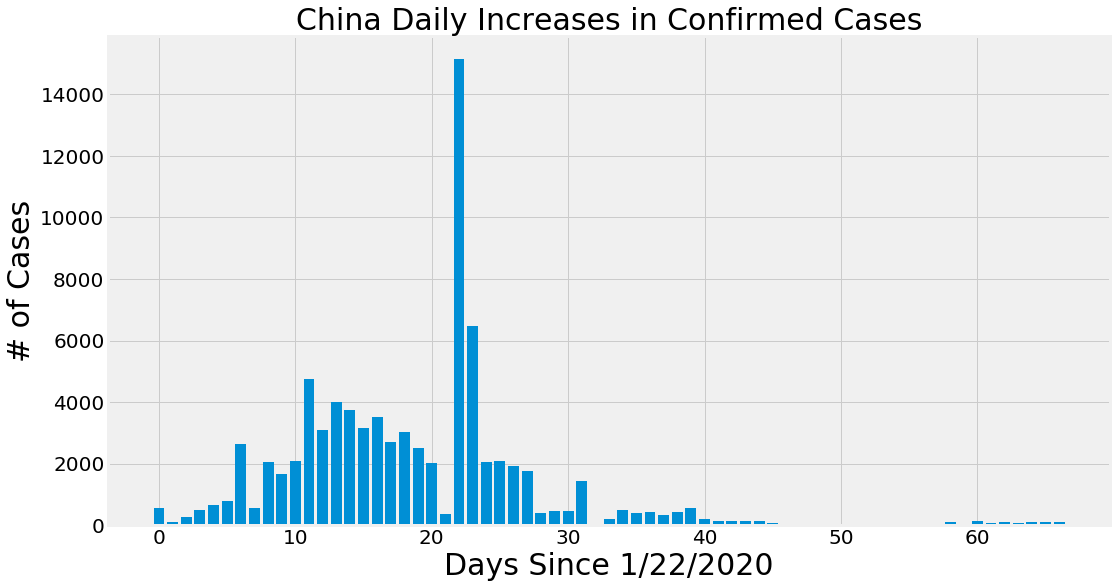

In [27]:
plt.figure(figsize=(16, 9))
plt.bar(adjusted_dates, china_daily_increase)
plt.title('China Daily Increases in Confirmed Cases', size=30)
plt.xlabel('Days Since 1/22/2020', size=30)
plt.ylabel('# of Cases', size=30)
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

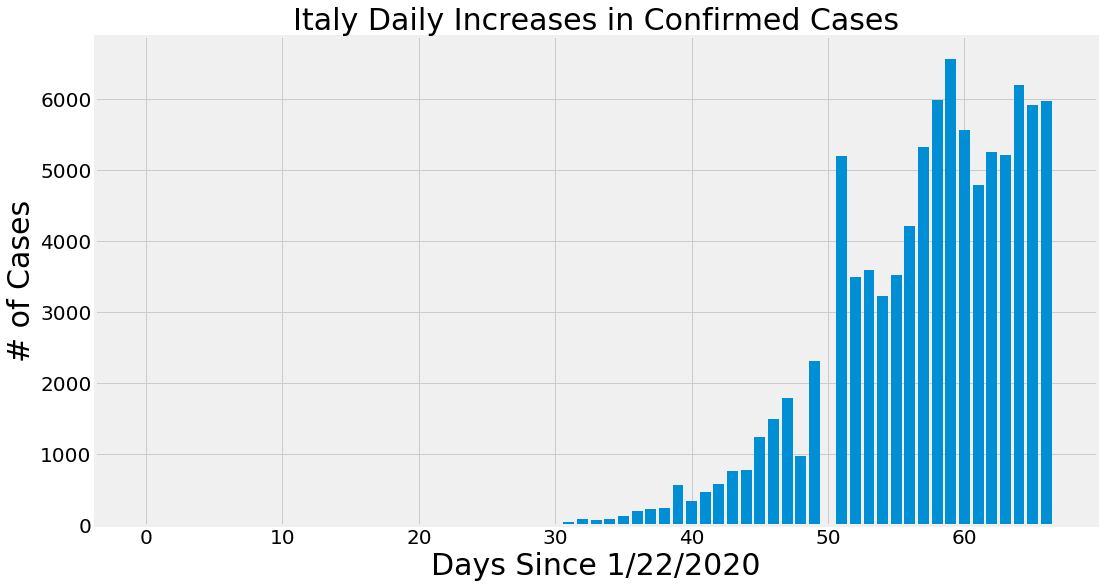

In [28]:
plt.figure(figsize=(16, 9))
plt.bar(adjusted_dates, italy_daily_increase)
plt.title('Italy Daily Increases in Confirmed Cases', size=30)
plt.xlabel('Days Since 1/22/2020', size=30)
plt.ylabel('# of Cases', size=30)
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

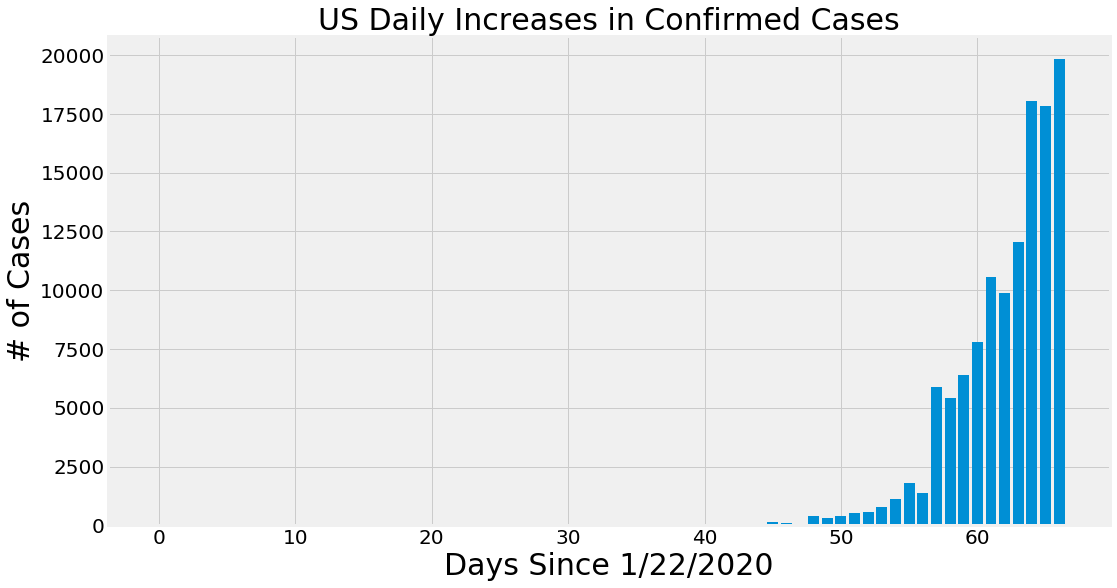

In [29]:
plt.figure(figsize=(16, 9))
plt.bar(adjusted_dates, us_daily_increase)
plt.title('US Daily Increases in Confirmed Cases', size=30)
plt.xlabel('Days Since 1/22/2020', size=30)
plt.ylabel('# of Cases', size=30)
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

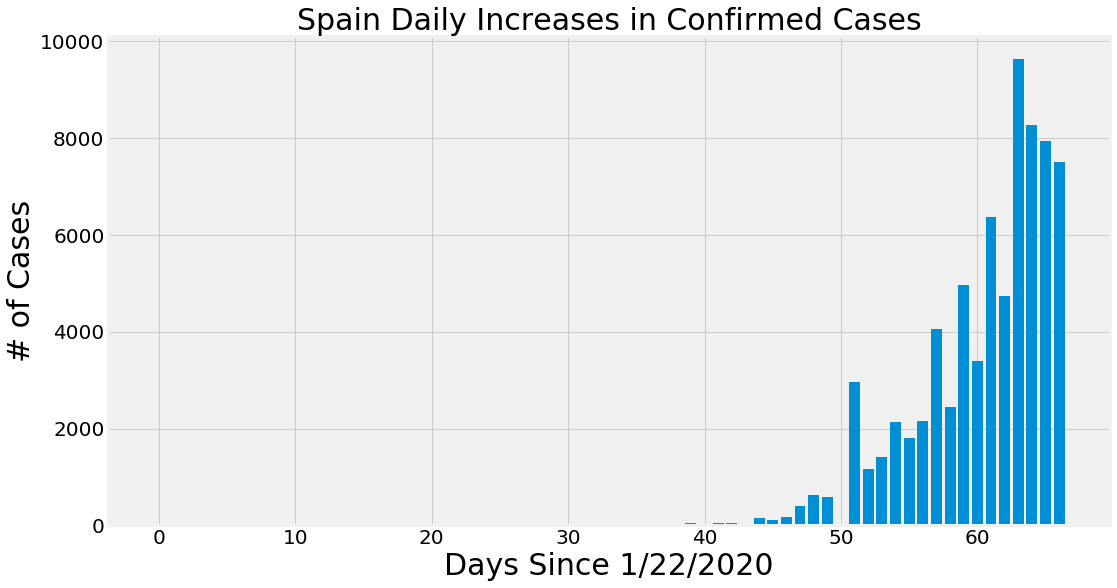

In [30]:
plt.figure(figsize=(16, 9))
plt.bar(adjusted_dates, spain_daily_increase)
plt.title('Spain Daily Increases in Confirmed Cases', size=30)
plt.xlabel('Days Since 1/22/2020', size=30)
plt.ylabel('# of Cases', size=30)
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

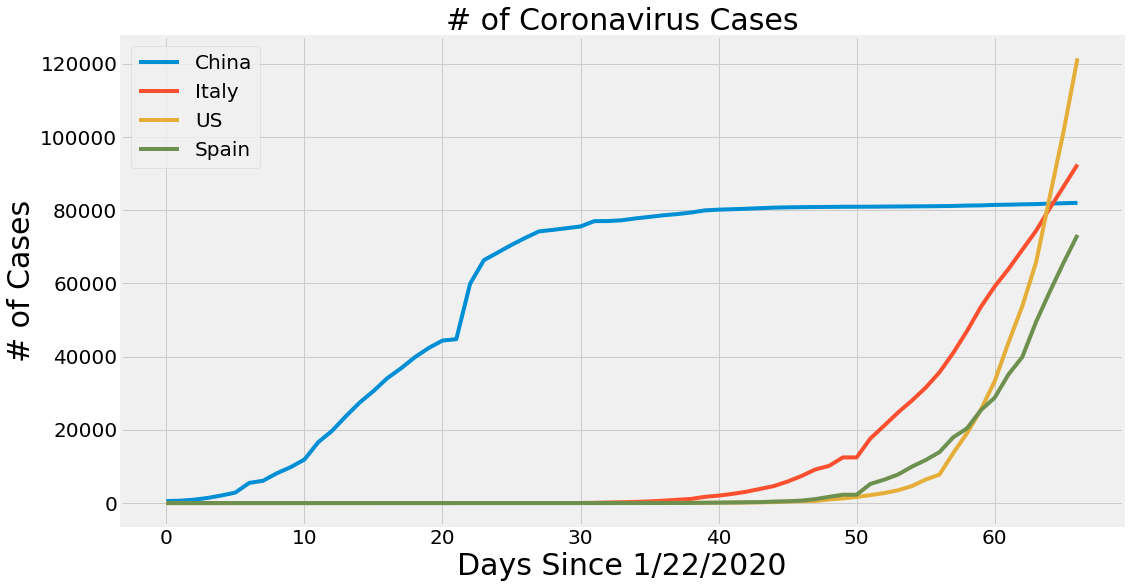

In [31]:
plt.figure(figsize=(16, 9))
plt.plot(adjusted_dates, china_cases)
plt.plot(adjusted_dates, italy_cases)
plt.plot(adjusted_dates, us_cases)
plt.plot(adjusted_dates, spain_cases)
plt.title('# of Coronavirus Cases', size=30)
plt.xlabel('Days Since 1/22/2020', size=30)
plt.ylabel('# of Cases', size=30)
plt.legend(['China', 'Italy', 'US', 'Spain'], prop={'size': 20})
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

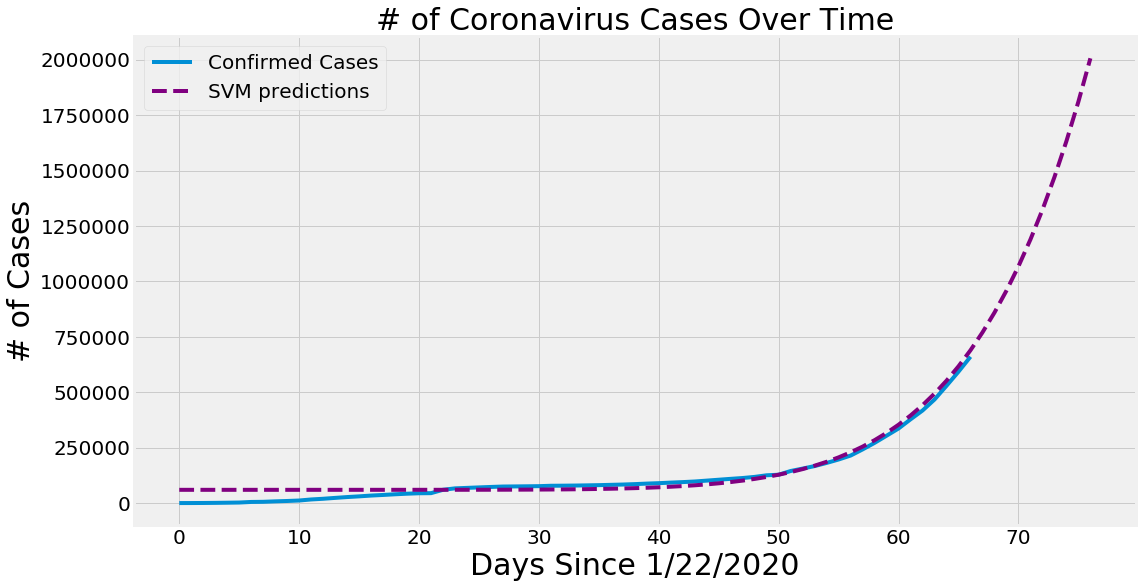

In [32]:
plt.figure(figsize=(16, 9))
plt.plot(adjusted_dates, world_cases)
plt.plot(future_forcast, svm_pred, linestyle='dashed', color='purple')
plt.title('# of Coronavirus Cases Over Time', size=30)
plt.xlabel('Days Since 1/22/2020', size=30)
plt.ylabel('# of Cases', size=30)
plt.legend(['Confirmed Cases', 'SVM predictions'], prop={'size': 20})
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

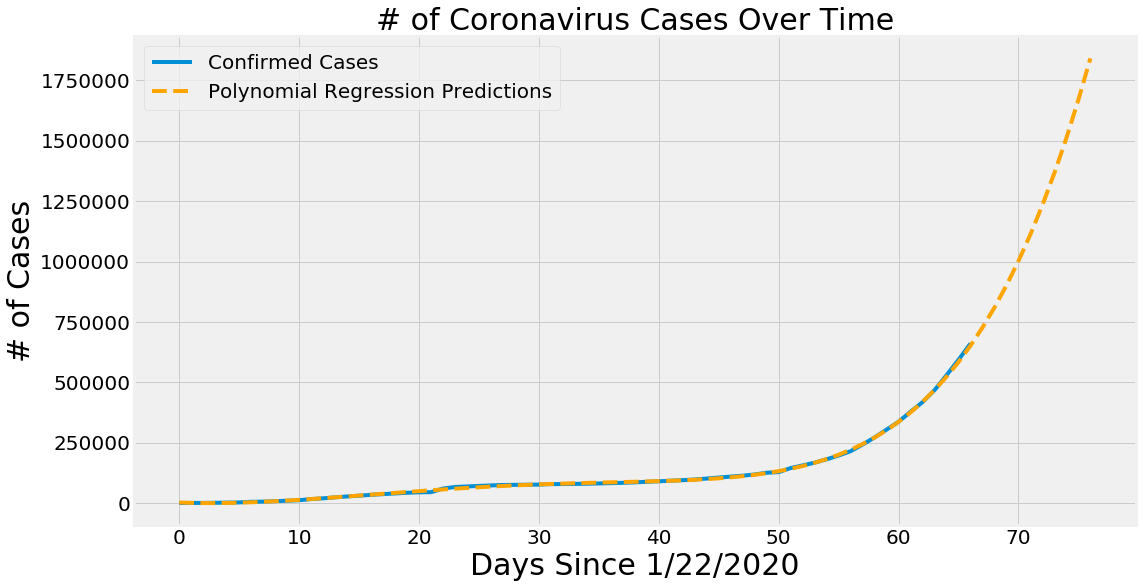

In [33]:
plt.figure(figsize=(16, 9))
plt.plot(adjusted_dates, world_cases)
plt.plot(future_forcast, linear_pred, linestyle='dashed', color='orange')
plt.title('# of Coronavirus Cases Over Time', size=30)
plt.xlabel('Days Since 1/22/2020', size=30)
plt.ylabel('# of Cases', size=30)
plt.legend(['Confirmed Cases', 'Polynomial Regression Predictions'], prop={'size': 20})
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

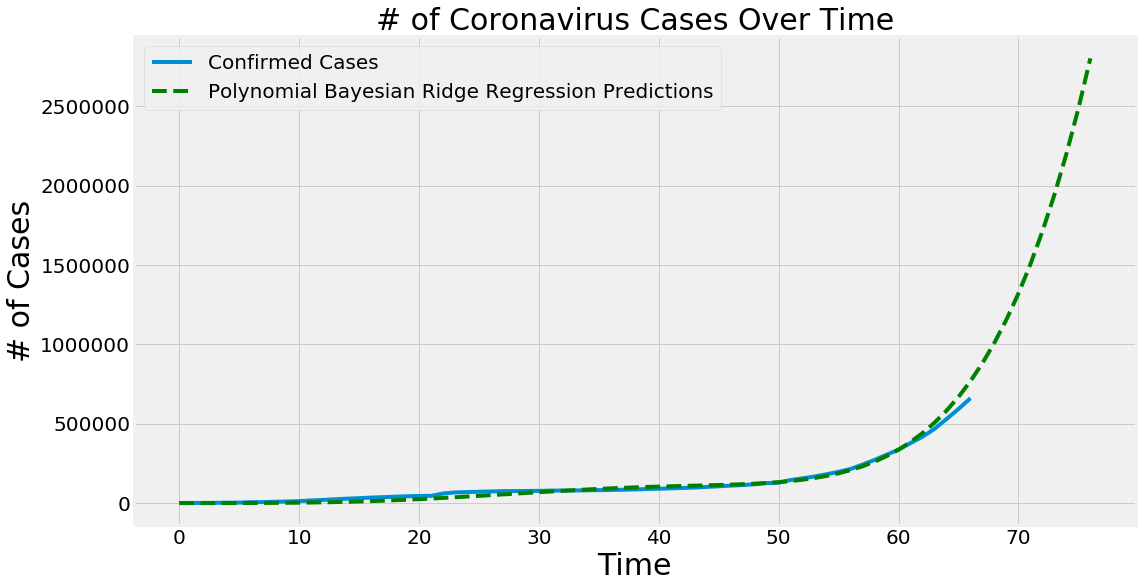

In [34]:
plt.figure(figsize=(16, 9))
plt.plot(adjusted_dates, world_cases)
plt.plot(future_forcast, bayesian_pred, linestyle='dashed', color='green')
plt.title('# of Coronavirus Cases Over Time', size=30)
plt.xlabel('Time', size=30)
plt.ylabel('# of Cases', size=30)
plt.legend(['Confirmed Cases', 'Polynomial Bayesian Ridge Regression Predictions'], prop={'size': 20})
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

In [35]:
# Future predictions using SVM 
print('SVM future predictions:')
set(zip(future_forcast_dates[-10:], np.round(svm_pred[-10:])))

SVM future predictions:


{('03/29/2020', 770431.0),
 ('03/30/2020', 859790.0),
 ('03/31/2020', 958838.0),
 ('04/01/2020', 1068459.0),
 ('04/02/2020', 1189609.0),
 ('04/03/2020', 1323311.0),
 ('04/04/2020', 1470663.0),
 ('04/05/2020', 1632844.0),
 ('04/06/2020', 1811113.0),
 ('04/07/2020', 2006821.0)}

In [36]:
# Future predictions using Polynomial Regression 
linear_pred = linear_pred.reshape(1,-1)[0]
print('Polynomial regression future predictions:')
set(zip(future_forcast_dates[-10:], np.round(linear_pred[-10:])))

Polynomial regression future predictions:


{('03/29/2020', 726968.0),
 ('03/30/2020', 809956.0),
 ('03/31/2020', 901479.0),
 ('04/01/2020', 1002197.0),
 ('04/02/2020', 1112809.0),
 ('04/03/2020', 1234051.0),
 ('04/04/2020', 1366697.0),
 ('04/05/2020', 1511561.0),
 ('04/06/2020', 1669501.0),
 ('04/07/2020', 1841418.0)}

In [37]:
# Future predictions using Linear Regression 
print('Ridge regression future predictions:')
set(zip(future_forcast_dates[-10:], np.round(bayesian_pred[-10:])))

Ridge regression future predictions:


{('03/29/2020', 882272.0),
 ('03/30/2020', 1011133.0),
 ('03/31/2020', 1156907.0),
 ('04/01/2020', 1321236.0),
 ('04/02/2020', 1505872.0),
 ('04/03/2020', 1712682.0),
 ('04/04/2020', 1943649.0),
 ('04/05/2020', 2200881.0),
 ('04/06/2020', 2486613.0),
 ('04/07/2020', 2803211.0)}

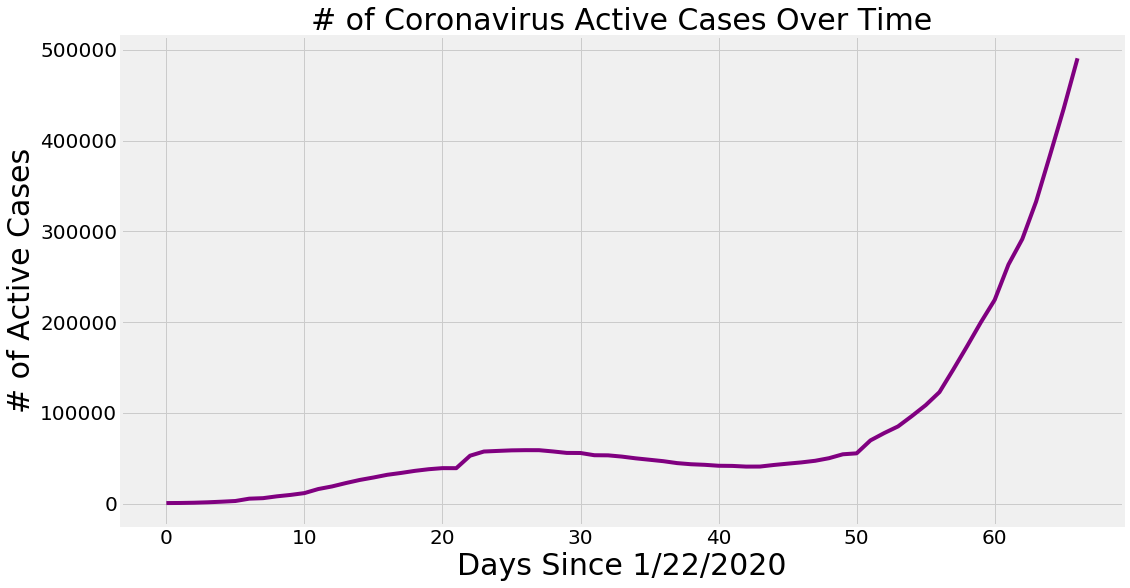

In [38]:
plt.figure(figsize=(16, 9))
plt.plot(adjusted_dates, total_active, color='purple')
plt.title('# of Coronavirus Active Cases Over Time', size=30)
plt.xlabel('Days Since 1/22/2020', size=30)
plt.ylabel('# of Active Cases', size=30)
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

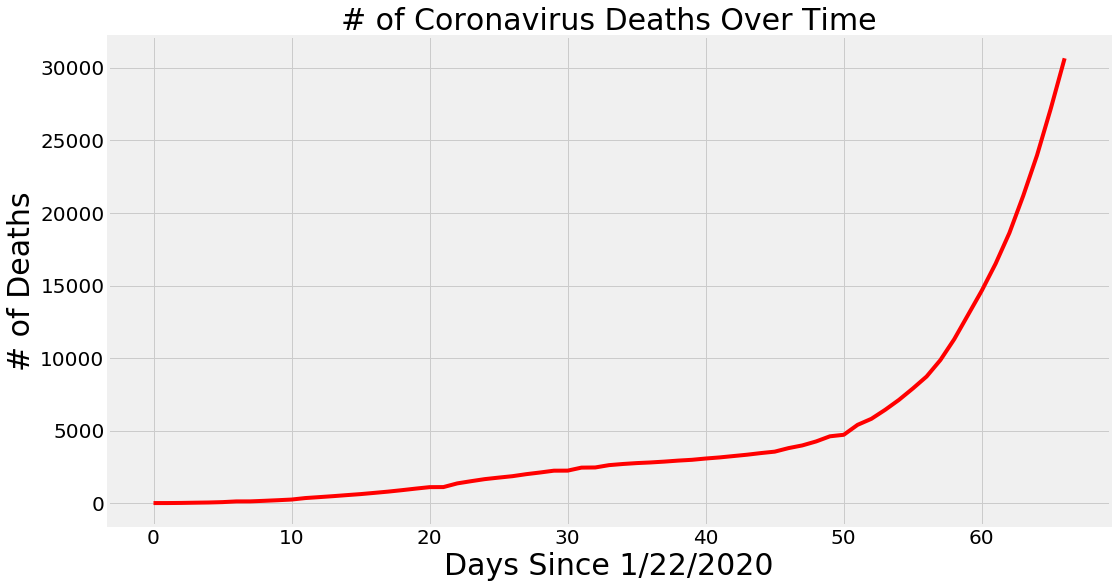

In [39]:
plt.figure(figsize=(16, 9))
plt.plot(adjusted_dates, total_deaths, color='red')
plt.title('# of Coronavirus Deaths Over Time', size=30)
plt.xlabel('Days Since 1/22/2020', size=30)
plt.ylabel('# of Deaths', size=30)
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

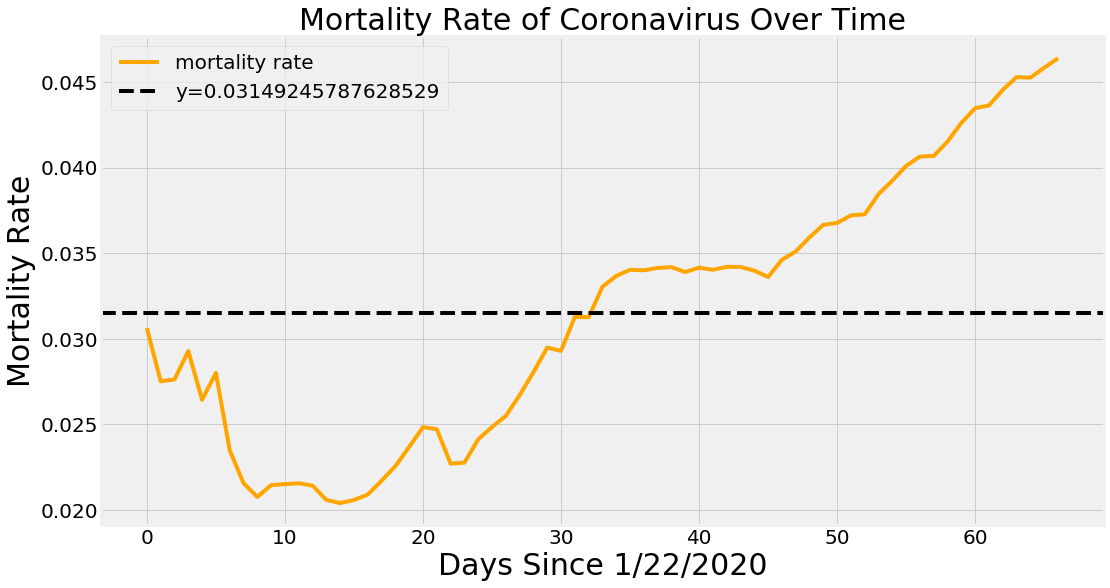

In [40]:
mean_mortality_rate = np.mean(mortality_rate)
plt.figure(figsize=(16, 9))
plt.plot(adjusted_dates, mortality_rate, color='orange')
plt.axhline(y = mean_mortality_rate,linestyle='--', color='black')
plt.title('Mortality Rate of Coronavirus Over Time', size=30)
plt.legend(['mortality rate', 'y='+str(mean_mortality_rate)], prop={'size': 20})
plt.xlabel('Days Since 1/22/2020', size=30)
plt.ylabel('Mortality Rate', size=30)
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

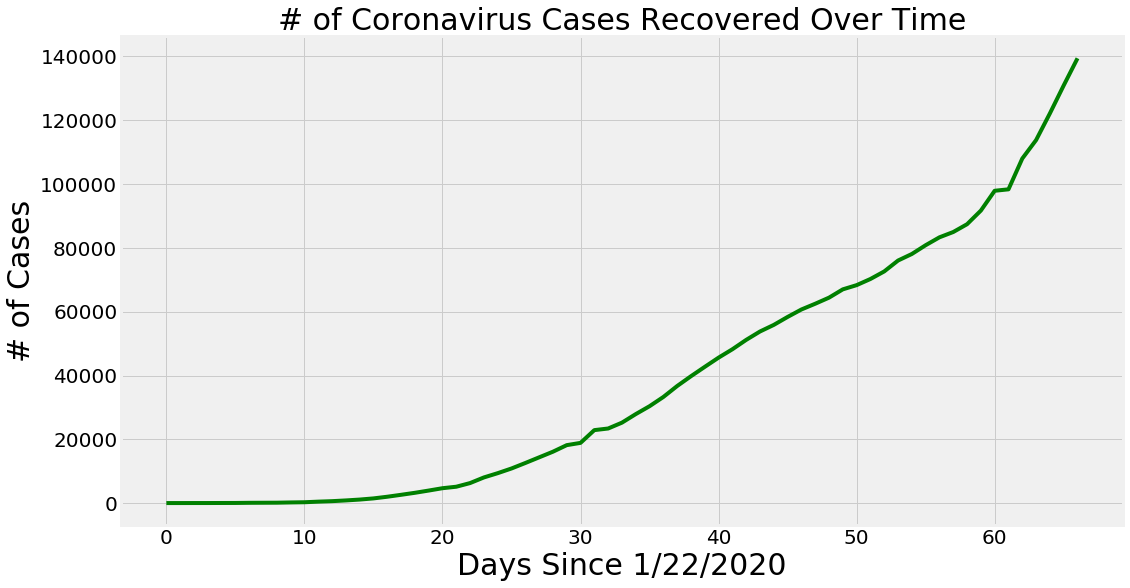

In [41]:
plt.figure(figsize=(16, 9))
plt.plot(adjusted_dates, total_recovered, color='green')
plt.title('# of Coronavirus Cases Recovered Over Time', size=30)
plt.xlabel('Days Since 1/22/2020', size=30)
plt.ylabel('# of Cases', size=30)
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

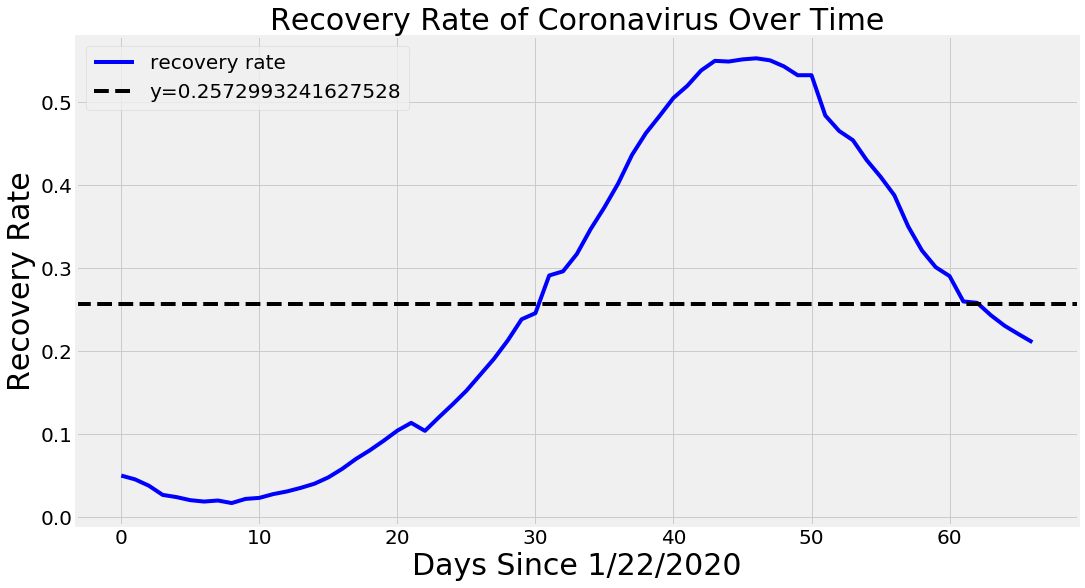

In [42]:
mean_recovery_rate = np.mean(recovery_rate)
plt.figure(figsize=(16, 9))
plt.plot(adjusted_dates, recovery_rate, color='blue')
plt.axhline(y = mean_recovery_rate,linestyle='--', color='black')
plt.title('Recovery Rate of Coronavirus Over Time', size=30)
plt.legend(['recovery rate', 'y='+str(mean_recovery_rate)], prop={'size': 20})
plt.xlabel('Days Since 1/22/2020', size=30)
plt.ylabel('Recovery Rate', size=30)
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

Graphing deaths against recoveries

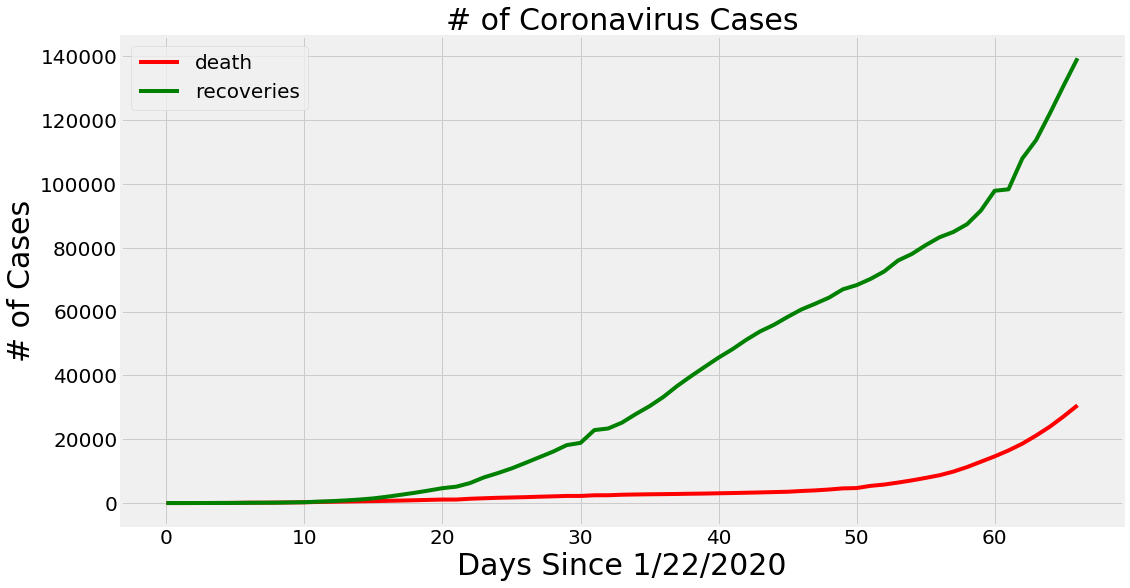

In [43]:
plt.figure(figsize=(16, 9))
plt.plot(adjusted_dates, total_deaths, color='r')
plt.plot(adjusted_dates, total_recovered, color='green')
plt.legend(['death', 'recoveries'], loc='best', fontsize=20)
plt.title('# of Coronavirus Cases', size=30)
plt.xlabel('Days Since 1/22/2020', size=30)
plt.ylabel('# of Cases', size=30)
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

Plotting the number of deaths against the number of recoveries

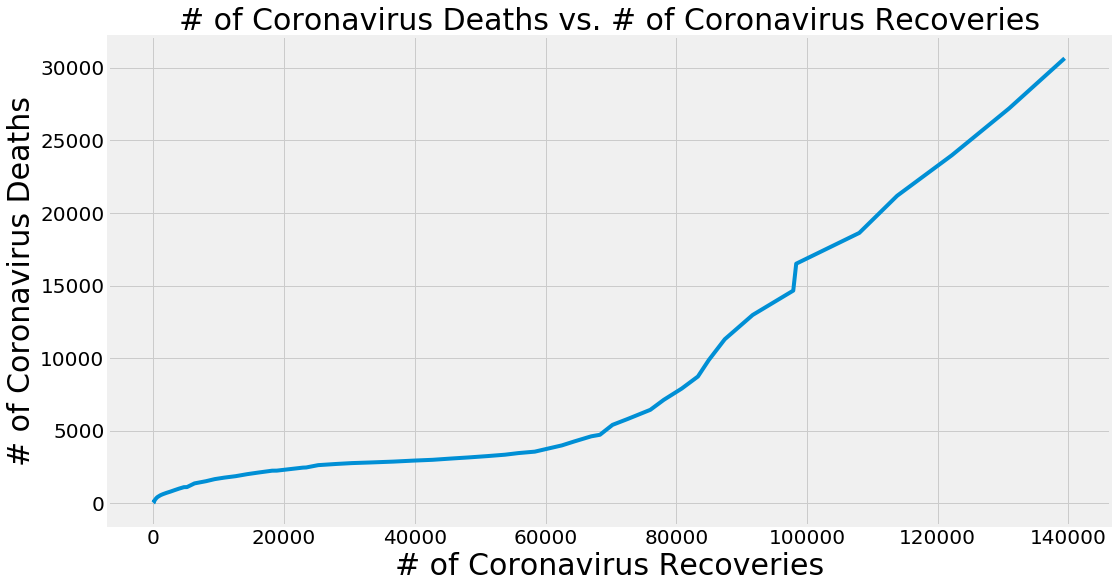

In [44]:
plt.figure(figsize=(16, 9))
plt.plot(total_recovered, total_deaths)
plt.title('# of Coronavirus Deaths vs. # of Coronavirus Recoveries', size=30)
plt.xlabel('# of Coronavirus Recoveries', size=30)
plt.ylabel('# of Coronavirus Deaths', size=30)
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

In [45]:
latest_confirmed = confirmed_df[dates[-1]]
latest_deaths = deaths_df[dates[-1]]
latest_recoveries = recoveries_df[dates[-1]]

Getting information about countries/regions that have confirmed coronavirus cases

In [46]:
unique_countries =  list(confirmed_df['Country/Region'].unique())

In [47]:
country_confirmed_cases = []
no_cases = []
for i in unique_countries:
    cases = latest_confirmed[confirmed_df['Country/Region']==i].sum()
    if cases > 0:
        country_confirmed_cases.append(cases)
    else:
        no_cases.append(i)
        
for i in no_cases:
    unique_countries.remove(i)
    
# sort countries by the number of confirmed cases
unique_countries = [k for k, v in sorted(zip(unique_countries, country_confirmed_cases), key=operator.itemgetter(1), reverse=True)]
for i in range(len(unique_countries)):
    country_confirmed_cases[i] = latest_confirmed[confirmed_df['Country/Region']==unique_countries[i]].sum()

In [48]:
# number of cases per country/region
print('Confirmed Cases by Countries/Regions:')
for i in range(len(unique_countries)):
    print(f'{unique_countries[i]}: {country_confirmed_cases[i]} cases')

Confirmed Cases by Countries/Regions:
US: 121478 cases
Italy: 92472 cases
China: 81999 cases
Spain: 73235 cases
Germany: 57695 cases
France: 38105 cases
Iran: 35408 cases
United Kingdom: 17312 cases
Switzerland: 14076 cases
Netherlands: 9819 cases
Korea, South: 9478 cases
Belgium: 9134 cases
Austria: 8271 cases
Turkey: 7402 cases
Canada: 5576 cases
Portugal: 5170 cases
Norway: 4015 cases
Brazil: 3904 cases
Australia: 3640 cases
Israel: 3619 cases
Sweden: 3447 cases
Czechia: 2631 cases
Ireland: 2415 cases
Denmark: 2366 cases
Malaysia: 2320 cases
Chile: 1909 cases
Luxembourg: 1831 cases
Ecuador: 1823 cases
Japan: 1693 cases
Poland: 1638 cases
Pakistan: 1495 cases
Romania: 1452 cases
Russia: 1264 cases
Thailand: 1245 cases
Saudi Arabia: 1203 cases
South Africa: 1187 cases
Finland: 1167 cases
Indonesia: 1155 cases
Philippines: 1075 cases
Greece: 1061 cases
India: 987 cases
Iceland: 963 cases
Singapore: 802 cases
Panama: 786 cases
Dominican Republic: 719 cases
Mexico: 717 cases
Diamond Prin

In [49]:
unique_provinces =  list(confirmed_df['Province/State'].unique())

Getting the latest information about provinces/states that have confirmed coronavirus cases

In [50]:
province_confirmed_cases = []
no_cases = [] 
for i in unique_provinces:
    cases = latest_confirmed[confirmed_df['Province/State']==i].sum()
    if cases > 0:
        province_confirmed_cases.append(cases)
    else:
        no_cases.append(i)
 
# remove areas with no confirmed cases
for i in no_cases:
    unique_provinces.remove(i)
    
unique_provinces = [k for k, v in sorted(zip(unique_provinces, province_confirmed_cases), key=operator.itemgetter(1), reverse=True)]
for i in range(len(unique_provinces)):
    province_confirmed_cases[i] = latest_confirmed[confirmed_df['Province/State']==unique_provinces[i]].sum()

In [51]:
# number of cases per province/state/city
print('Confirmed Cases by Province/States:')
for i in range(len(unique_provinces)):
    print(f'{unique_provinces[i]}: {province_confirmed_cases[i]} cases')

Confirmed Cases by Province/States:
Hubei: 67801 cases
Quebec: 2498 cases
New South Wales: 1617 cases
Guangdong: 1467 cases
Henan: 1275 cases
Zhejiang: 1251 cases
Ontario: 1144 cases
Hunan: 1018 cases
Anhui: 990 cases
Jiangxi: 936 cases
British Columbia: 884 cases
Shandong: 772 cases
Victoria: 685 cases
Jiangsu: 641 cases
Queensland: 625 cases
Chongqing: 578 cases
Beijing: 573 cases
Hong Kong: 561 cases
Sichuan: 548 cases
Alberta: 542 cases
Shanghai: 485 cases
Heilongjiang: 484 cases
Fujian: 337 cases
Hebei: 319 cases
South Australia: 287 cases
Western Australia: 278 cases
Guangxi: 254 cases
Shaanxi: 253 cases
Reunion: 183 cases
Yunnan: 180 cases
Hainan: 168 cases
Tianjin: 161 cases
Faroe Islands: 155 cases
Guizhou: 146 cases
Gansu: 136 cases
Shanxi: 135 cases
Saskatchewan: 134 cases
Liaoning: 132 cases
Newfoundland and Labrador: 120 cases
Nova Scotia: 110 cases
Guadeloupe: 102 cases
Jilin: 97 cases
Channel Islands: 97 cases
Inner Mongolia: 94 cases
Martinique: 93 cases
Xinjiang: 76 ca

In [52]:
nan_indices = [] 

# handle nan if there is any, it is usually a float: float('nan')

for i in range(len(unique_provinces)):
    if type(unique_provinces[i]) == float:
        nan_indices.append(i)

unique_provinces = list(unique_provinces)
province_confirmed_cases = list(province_confirmed_cases)

for i in nan_indices:
    unique_provinces.pop(i)
    province_confirmed_cases.pop(i)

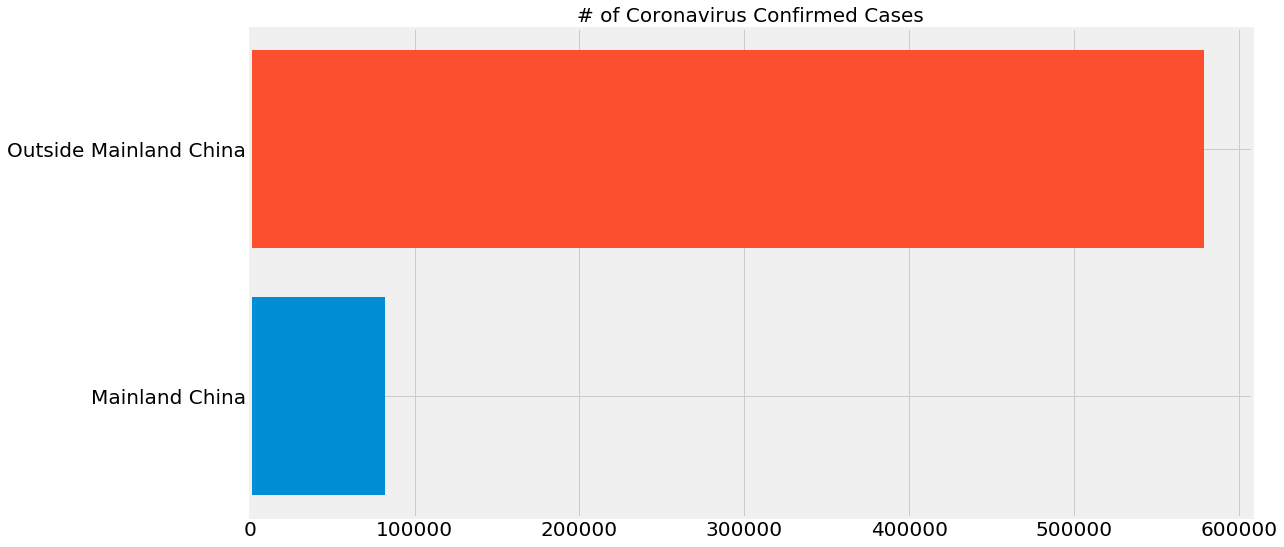

In [53]:
china_confirmed = latest_confirmed[confirmed_df['Country/Region']=='China'].sum()
outside_mainland_china_confirmed = np.sum(country_confirmed_cases) - china_confirmed
plt.figure(figsize=(16, 9))
plt.barh('Mainland China', china_confirmed)
plt.barh('Outside Mainland China', outside_mainland_china_confirmed)
plt.title('# of Coronavirus Confirmed Cases', size=20)
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

In [54]:
print('Outside Mainland China {} cases:'.format(outside_mainland_china_confirmed))
print('Mainland China: {} cases'.format(china_confirmed))
print('Total: {} cases'.format(china_confirmed+outside_mainland_china_confirmed))

Outside Mainland China 578707 cases:
Mainland China: 81999 cases
Total: 660706 cases


In [55]:
# Only show 10 countries with the most confirmed cases, the rest are grouped into the other category
visual_unique_countries = [] 
visual_confirmed_cases = []
others = np.sum(country_confirmed_cases[10:])

for i in range(len(country_confirmed_cases[:10])):
    visual_unique_countries.append(unique_countries[i])
    visual_confirmed_cases.append(country_confirmed_cases[i])
    
visual_unique_countries.append('Others')
visual_confirmed_cases.append(others)

***Visual Representations*** (bar charts and pie charts)

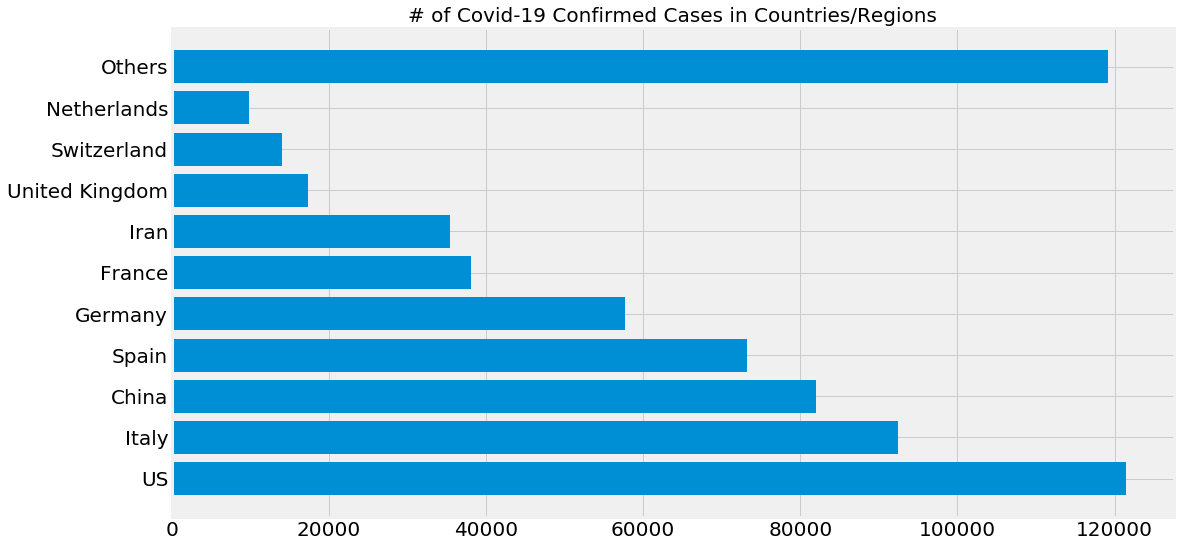

In [56]:
plt.figure(figsize=(16, 9))
plt.barh(visual_unique_countries, visual_confirmed_cases)
plt.title('# of Covid-19 Confirmed Cases in Countries/Regions', size=20)
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

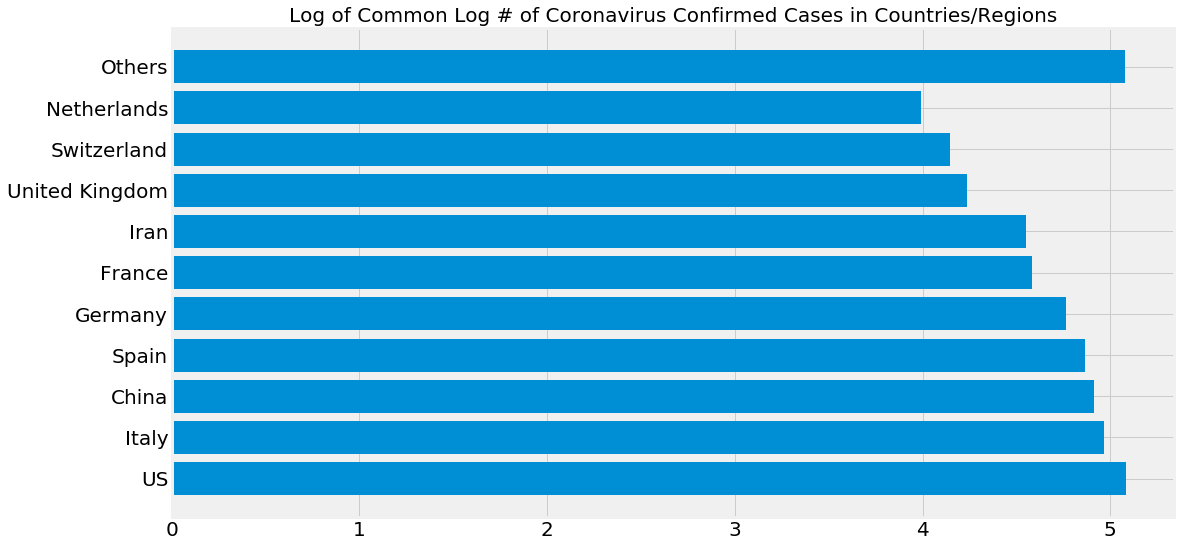

In [57]:
# lets look at it in a logarithmic scale 
log_country_confirmed_cases = [math.log10(i) for i in visual_confirmed_cases]
plt.figure(figsize=(16, 9))
plt.barh(visual_unique_countries, log_country_confirmed_cases)
plt.title('Log of Common Log # of Coronavirus Confirmed Cases in Countries/Regions', size=20)
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

In [58]:
# Only show 10 provinces with the most confirmed cases, the rest are grouped into the other category
visual_unique_provinces = [] 
visual_confirmed_cases2 = []
others = np.sum(province_confirmed_cases[10:])
for i in range(len(province_confirmed_cases[:10])):
    visual_unique_provinces.append(unique_provinces[i])
    visual_confirmed_cases2.append(province_confirmed_cases[i])

visual_unique_provinces.append('Others')
visual_confirmed_cases2.append(others)

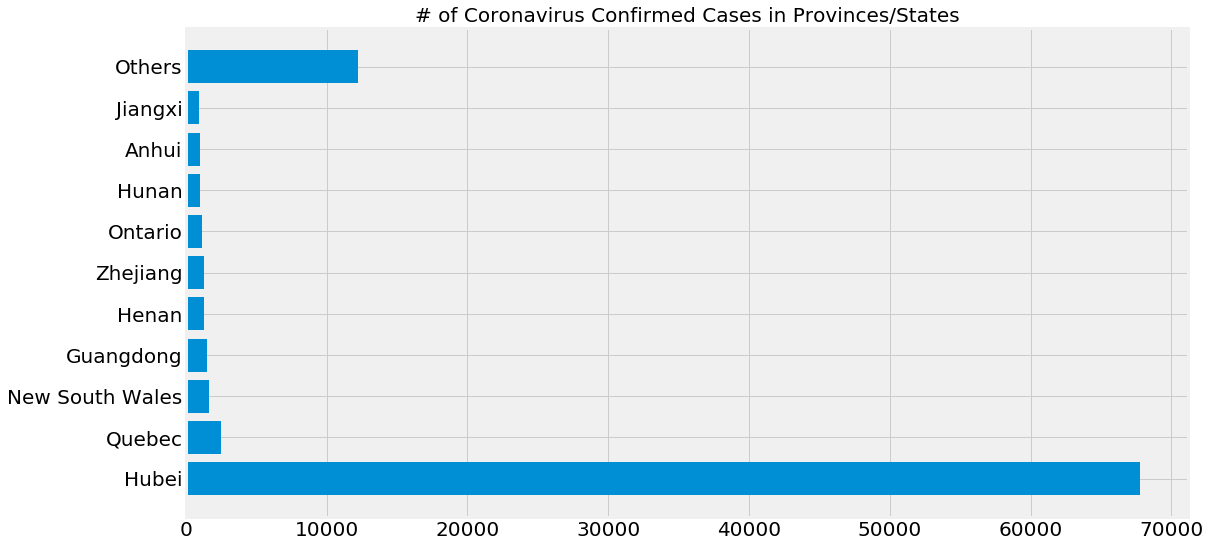

In [59]:
plt.figure(figsize=(16, 9))
plt.barh(visual_unique_provinces, visual_confirmed_cases2)
plt.title('# of Coronavirus Confirmed Cases in Provinces/States', size=20)
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

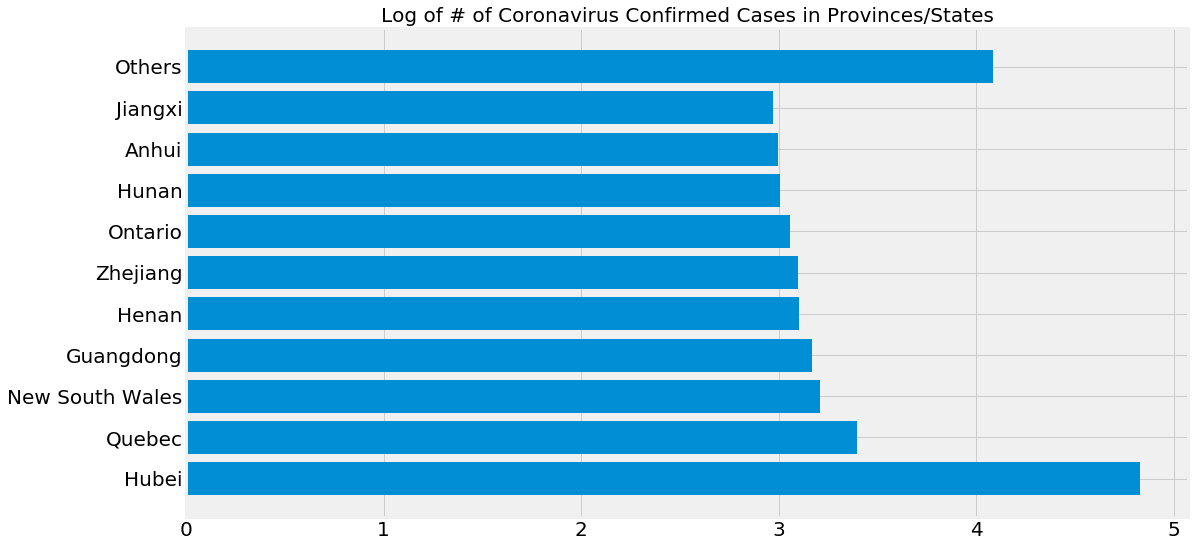

In [60]:
log_province_confirmed_cases = [math.log10(i) for i in visual_confirmed_cases2]
plt.figure(figsize=(16, 9))
plt.barh(visual_unique_provinces, log_province_confirmed_cases)
plt.title('Log of # of Coronavirus Confirmed Cases in Provinces/States', size=20)
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

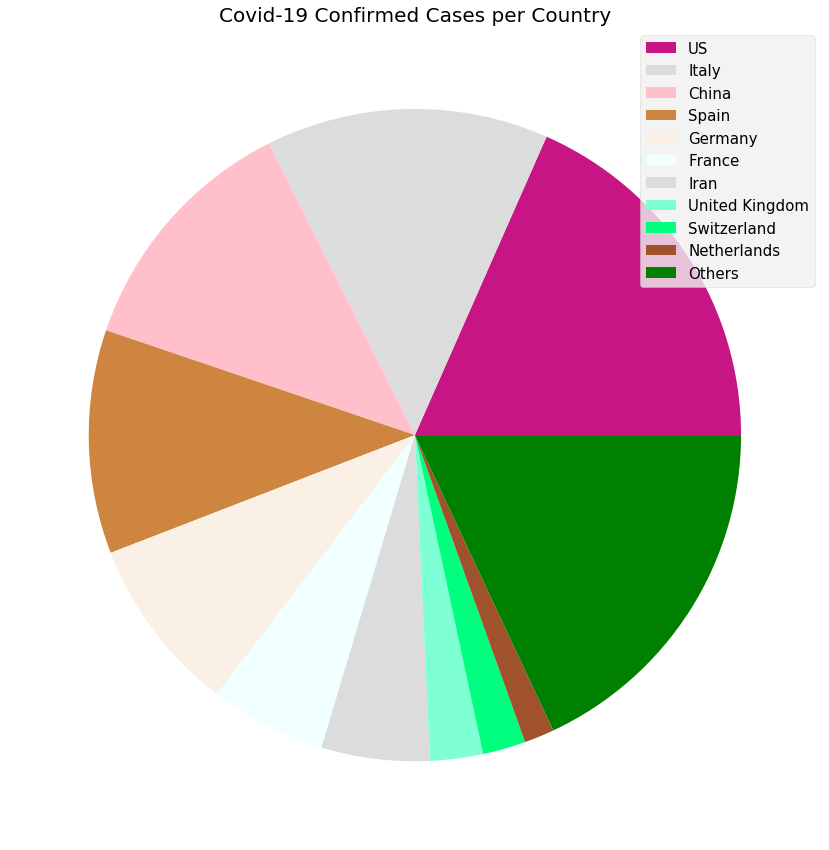

In [61]:
c = random.choices(list(mcolors.CSS4_COLORS.values()),k = len(unique_countries))
plt.figure(figsize=(20,15))
plt.title('Covid-19 Confirmed Cases per Country', size=20)
plt.pie(visual_confirmed_cases, colors=c)
plt.legend(visual_unique_countries, loc='best', fontsize=15)
plt.show()

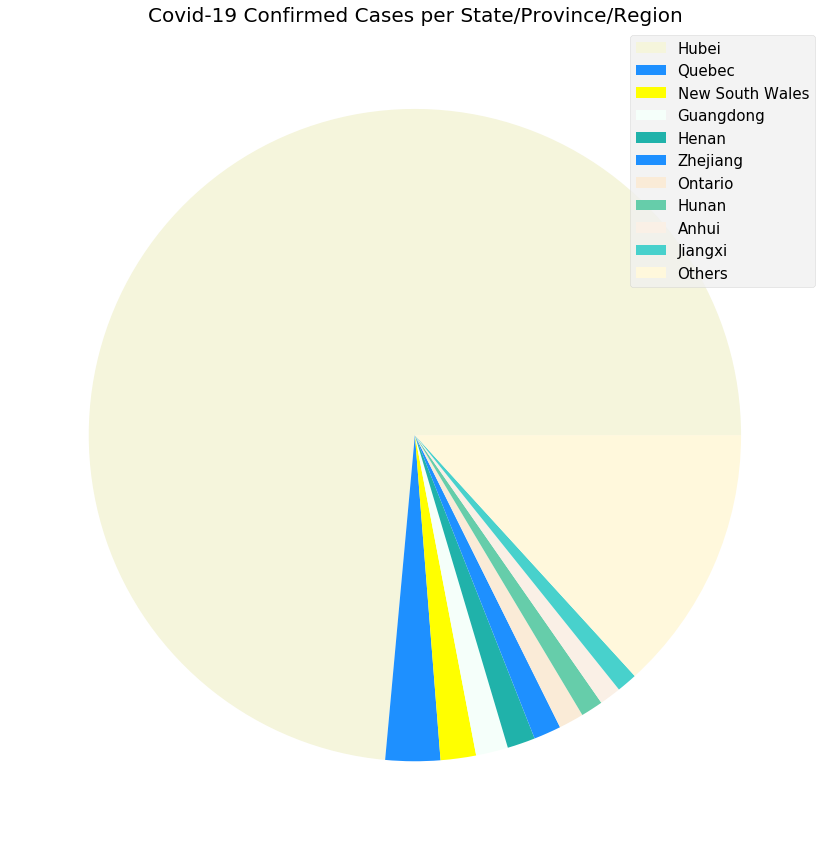

In [62]:
c = random.choices(list(mcolors.CSS4_COLORS.values()),k = len(unique_countries))
plt.figure(figsize=(20,15))
plt.title('Covid-19 Confirmed Cases per State/Province/Region', size=20)
plt.pie(visual_confirmed_cases2, colors=c)
plt.legend(visual_unique_provinces, loc='best', fontsize=15)
plt.show()

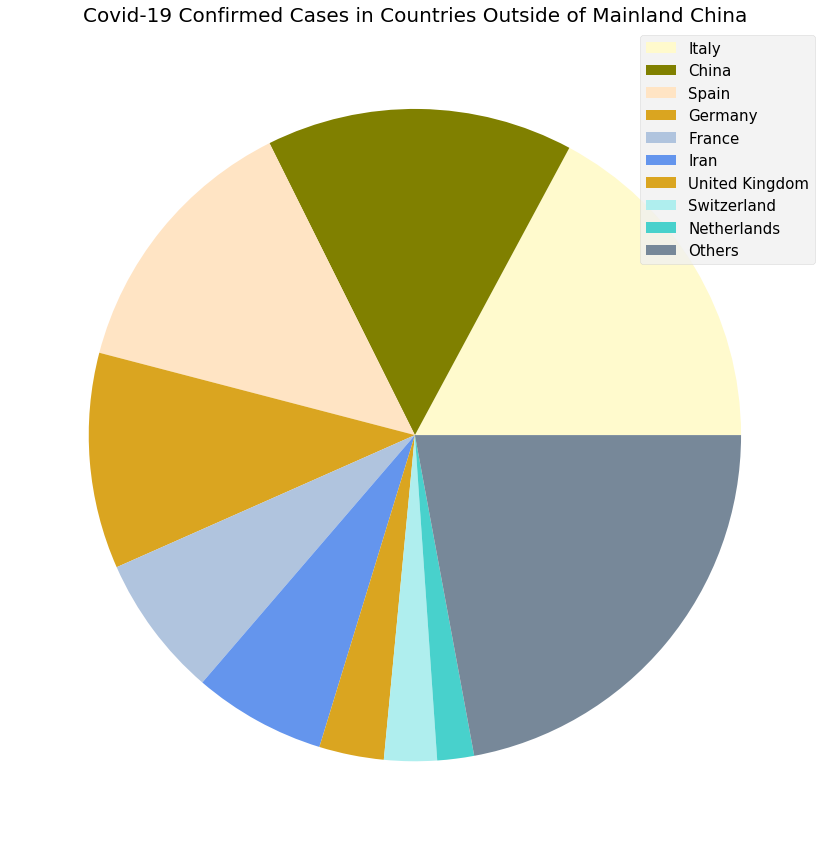

In [63]:
c = random.choices(list(mcolors.CSS4_COLORS.values()),k = len(unique_countries))
plt.figure(figsize=(20,15))
plt.title('Covid-19 Confirmed Cases in Countries Outside of Mainland China', size=20)
plt.pie(visual_confirmed_cases[1:], colors=c)
plt.legend(visual_unique_countries[1:], loc='best', fontsize=15)
plt.show()

In [64]:
# # looking at US States
# us_regions = list(confirmed_df[confirmed_df['Country/Region']=='US']['Province/State'].unique())
# us_confirmed_cases = []
# no_cases = [] 
# for i in us_regions:
#     cases = latest_confirmed[confirmed_df['Province/State']==i].sum()
#     if cases > 0:
#         us_confirmed_cases.append(cases)
#     else:
#         no_cases.append(i)
 
# # remove areas with no confirmed cases
# for i in no_cases:
#     us_regions.remove(i)
    
# # only show the top 10 states
# us_regions = [k for k, v in sorted(zip(us_regions, us_confirmed_cases), key=operator.itemgetter(1), reverse=True)]

# for i in range(len(us_regions)):
#     us_confirmed_cases[i] = latest_confirmed[confirmed_df['Province/State']==us_regions[i]].sum()  

# us_regions_10 = us_regions[:10]
# us_regions_10.append('Others')
# us_confirmed_cases_10 = us_confirmed_cases[:10]
# us_confirmed_cases_10.append(np.sum(us_confirmed_cases[10:]))

In [65]:
# c = random.choices(list(mcolors.CSS4_COLORS.values()),k = len(unique_countries))
# plt.figure(figsize=(20,15))
# plt.title('Covid-19 Confirmed Cases in the United States',  size=20)
# plt.pie(us_confirmed_cases_10, colors=c)
# plt.legend(us_regions_10, loc='best', fontsize=15)
# plt.show()

In [66]:
# looking at Chinese provinces
china_regions = list(confirmed_df[confirmed_df['Country/Region']=='China']['Province/State'].unique())
china_confirmed_cases = []
no_cases = [] 
for i in china_regions:
    cases = latest_confirmed[confirmed_df['Province/State']==i].sum()
    if cases > 0:
        china_confirmed_cases.append(cases)
    else:
        no_cases.append(i)
 
# remove areas with no confirmed cases
for i in no_cases:
    china_confirmed_cases.remove(i)
    
china_regions = [k for k, v in sorted(zip(china_regions, china_confirmed_cases), key=operator.itemgetter(1), reverse=True)]

for i in range(len(china_regions)):
    china_confirmed_cases[i] = latest_confirmed[confirmed_df['Province/State']==china_regions[i]].sum()  

china_regions_10 = china_regions[:10]
china_regions_10.append('Others')
china_confirmed_cases_10 = china_confirmed_cases[:10]
china_confirmed_cases_10.append(np.sum(china_confirmed_cases[10:]))

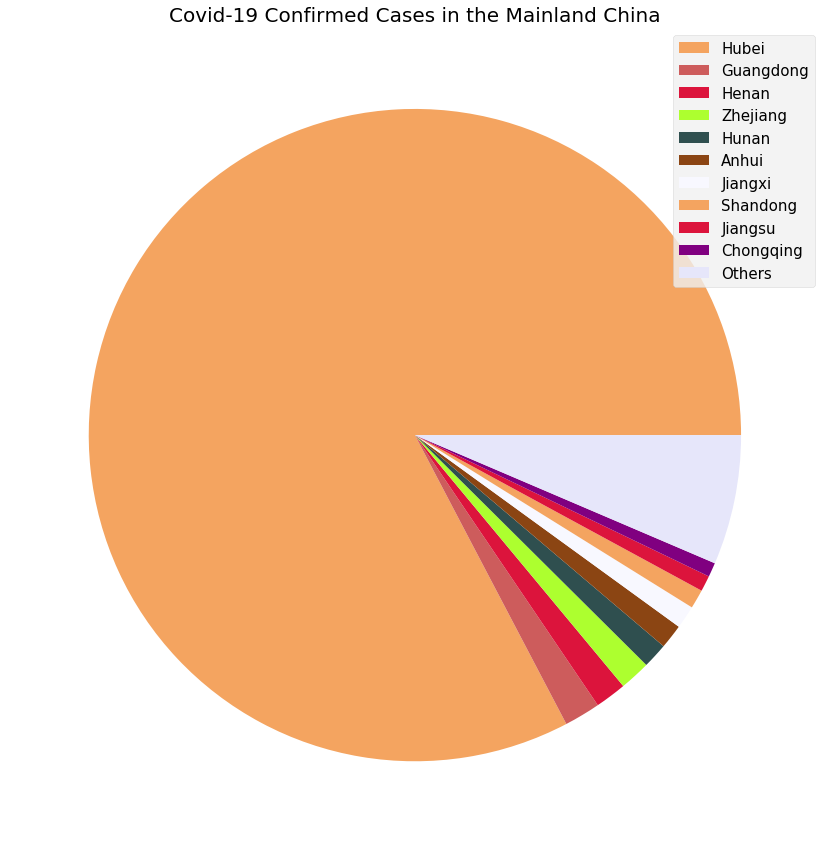

In [67]:
c = random.choices(list(mcolors.CSS4_COLORS.values()),k = len(unique_countries))
plt.figure(figsize=(20,15))
plt.title('Covid-19 Confirmed Cases in the Mainland China', size=20)
plt.pie(china_confirmed_cases_10, colors=c)
plt.legend(china_regions_10, loc='best', fontsize=15)
plt.show()